# Kaggle May 2021 monthly challenge
This notebook was built to explore the Kaggle May 2021 monthly challenge.

## Imports

In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
%matplotlib inline

## The rundown
There are 50 features - we don't know exactly what they represent. They are used to predict belonging to one of four classes. We need to predict the likelihood of belonging to each.

There are 100,000 rows in the training dataset and 50,000 in the test set.

## Load the data
We'll load training data and examine the class/feature relationships. Then we'll load the test data, and glue the two together to examine them. We'll also get rid of the 'id' column, since it isn't necessary.

In [4]:
train_all = pd.read_csv('~/Data/Kaggle/May2021/train.csv') 
test_X = pd.read_csv('~/Data/Kaggle/May2021/test.csv')

In [5]:
train_y = train_all['target']

In [6]:
train_X = train_all.drop('id', axis=1)
test_X = test_X.drop('id', axis=1)                        

## Investigate the data

In [7]:
# Are there any missing values for features?
test_X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
feature_0,50000.000000,0.254620,0.910607,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,50000.000000,0.443480,2.004536,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,50000.000000,0.116720,0.524807,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,50000.000000,0.584440,1.814083,0.000000,0.000000,0.000000,0.000000,25.000000
feature_4,50000.000000,0.612640,2.819580,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,50000.000000,0.161500,0.605760,0.000000,0.000000,0.000000,0.000000,9.000000
feature_6,50000.000000,0.746000,2.352495,0.000000,0.000000,0.000000,0.000000,25.000000
feature_7,50000.000000,1.238040,2.728055,0.000000,0.000000,0.000000,1.000000,29.000000
feature_8,50000.000000,0.886440,3.364154,0.000000,0.000000,0.000000,0.000000,35.000000
feature_9,50000.000000,0.941920,1.913358,0.000000,0.000000,0.000000,1.000000,16.000000


In [8]:
train_X.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
feature_0,100000.000000,0.257830,0.929033,0.000000,0.000000,0.000000,0.000000,10.000000
feature_1,100000.000000,0.431720,1.977862,0.000000,0.000000,0.000000,0.000000,31.000000
feature_2,100000.000000,0.114130,0.519584,0.000000,0.000000,0.000000,0.000000,6.000000
feature_3,100000.000000,0.590550,1.844558,0.000000,0.000000,0.000000,0.000000,26.000000
feature_4,100000.000000,0.599770,2.785531,0.000000,0.000000,0.000000,0.000000,38.000000
feature_5,100000.000000,0.160820,0.601149,0.000000,0.000000,0.000000,0.000000,10.000000
feature_6,100000.000000,0.731490,2.343465,0.000000,0.000000,0.000000,0.000000,27.000000
feature_7,100000.000000,1.228920,2.692732,0.000000,0.000000,0.000000,1.000000,31.000000
feature_8,100000.000000,0.903350,3.415258,0.000000,0.000000,0.000000,0.000000,39.000000
feature_9,100000.000000,0.940120,1.904172,0.000000,0.000000,0.000000,1.000000,17.000000


From the above, it looks like the features are all heavily skewed toward smaller values. That checks out from the data overview given in the challenge docs. It looks like most of the entries in each feature are 0. Feature 42 had a minimum value of 0 in the training set and -2 in the test set, so we'll see how weird that turns out to be. Otherwise, the summaries of the training and test sets did not reveal any material difference in distribution. However, it does look like there's some differences in the range of some features between the training and test sets, so if we do scaling we might want to combine them first.

In [9]:
# Any duplicate rows in the training set?
train_X[train_X.drop('target', axis=1).duplicated(keep='first')]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
44423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_4
73244,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2
80571,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_4
89009,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_1


In [10]:
train_X[train_X.drop('target', axis=1).duplicated(keep='last')]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
13230,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2
25648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_4
44248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Class_2
87104,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Class_3


In [11]:
# Need to get rid of these
train_X = train_X.drop([44423, 73244,80571,89009,13230,25648,44248,87104])

In [12]:
train_y = train_y.drop([44423, 73244,80571,89009,13230,25648,44248,87104])
train_y_num = [int(x[-1])-1 for x in train_y] # Keep just the integer description

In [13]:
# Any training rows that are also in the test set?
data_X = train_X.drop('target',axis=1).append(test_X, ignore_index = True)
data_X[data_X.duplicated(keep='first')]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49
101165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
120746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
132008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
143128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
143290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
train_test_dupes = data_X[data_X.duplicated(keep='last')].index
save_preds = train_X.loc[train_test_dupes, 'target']

In [15]:
# Find the pairs
for i in train_test_dupes:
    for j in data_X[data_X.duplicated(keep='first')].index:
        if data_X.loc[i].equals(data_X.loc[j]):
            print(i,j)

23271 143290
31715 132008
36456 143128
62186 114762
63139 101165
81432 120746


In [16]:
# Hang on to these - we'll force the matching rows in test to these predictions later
save_preds

23271    Class_2
31715    Class_3
36456    Class_3
62186    Class_4
63139    Class_3
81432    Class_2
Name: target, dtype: object

In [17]:
data_X.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

## Check pairwise correlations

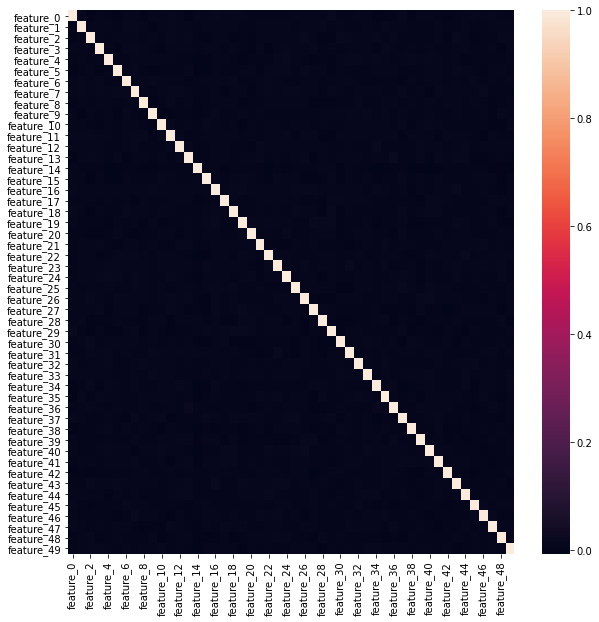

In [18]:
datacorr = data_X.corr()
plt.subplots(figsize=(10,10))
sns.heatmap(datacorr)
plt.show()

It appears that no two columns are correlated. Running `data_X.dtypes` shows that the data are all integers. I was going to look up and research how to do a batch KDE plot of each column, but other contestants have done that, so I shamelessly stole it.

### Show disribution of class predictions
First we'll show the distribution of target classes generally. Then we'll show it with respect to each feature separately.

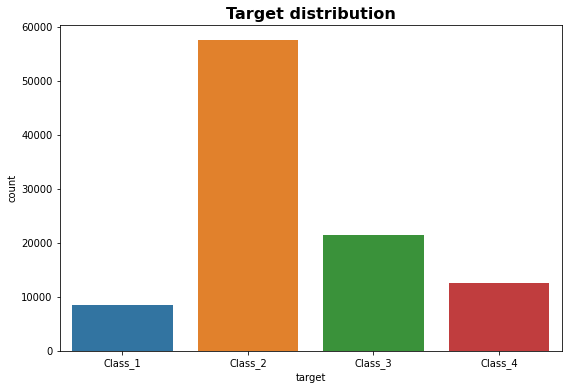

In [19]:
fig, ax = plt.subplots(figsize=(9,6))
sns.countplot(data=train_y, x=train_y, order=sorted(train_y.unique()), ax=ax)
ax.set_title("Target distribution", size=16, weight='bold')
plt.show()

So it seems like you could make a naive predction by just saying everything belongs to Class_2. Or you could assign to each class this relative distribution.

### Baseline prediction
Class 2 probability = 1, all others = 0 for all test rows.

In [20]:
submission1 = pd.DataFrame(columns=['Class_1','Class_2','Class_3','Class_4'], index=test_X.index+100000)

In [21]:
submission1.fillna(0.0, inplace=True)
submission1.Class_2 = 1.0
submission1.index.name = 'id'
submission1.head()

,Class_1,Class_2,Class_3,Class_4
id,,,,
100000,0.0,1.0,0.0,0.0
100001,0.0,1.0,0.0,0.0
100002,0.0,1.0,0.0,0.0
100003,0.0,1.0,0.0,0.0
100004,0.0,1.0,0.0,0.0


In [22]:
submission1.to_csv('naive_submission.csv', header=True)

Score was 14.622 - which is pretty bad. That's what I expected. Let's try the other dumb way, which is to assign to each submission column the proportion of each class label in the training set.

In [23]:
naive2 = train_X['target'].value_counts()/len(train_X)
submission2 = pd.DataFrame(columns=['Class_1','Class_2','Class_3','Class_4'], index=test_X.index+100000)
submission2.Class_1 = naive2.Class_1
submission2.Class_2 = naive2.Class_2
submission2.Class_3 = naive2.Class_3
submission2.Class_4 = naive2.Class_4
submission2.index.name = 'id'
submission2.head()

,Class_1,Class_2,Class_3,Class_4
id,,,,
100000,0.084897,0.574986,0.214207,0.12591
100001,0.084897,0.574986,0.214207,0.12591
100002,0.084897,0.574986,0.214207,0.12591
100003,0.084897,0.574986,0.214207,0.12591
100004,0.084897,0.574986,0.214207,0.12591


In [24]:
submission2.to_csv('naive2_submission.csv', header=True)

Score was 1.11371 which is much better, but still behind the top performers. The difference between me and numero uno right now was 0.04 in public score, and I'm in 545th place.

## Continue exploring data

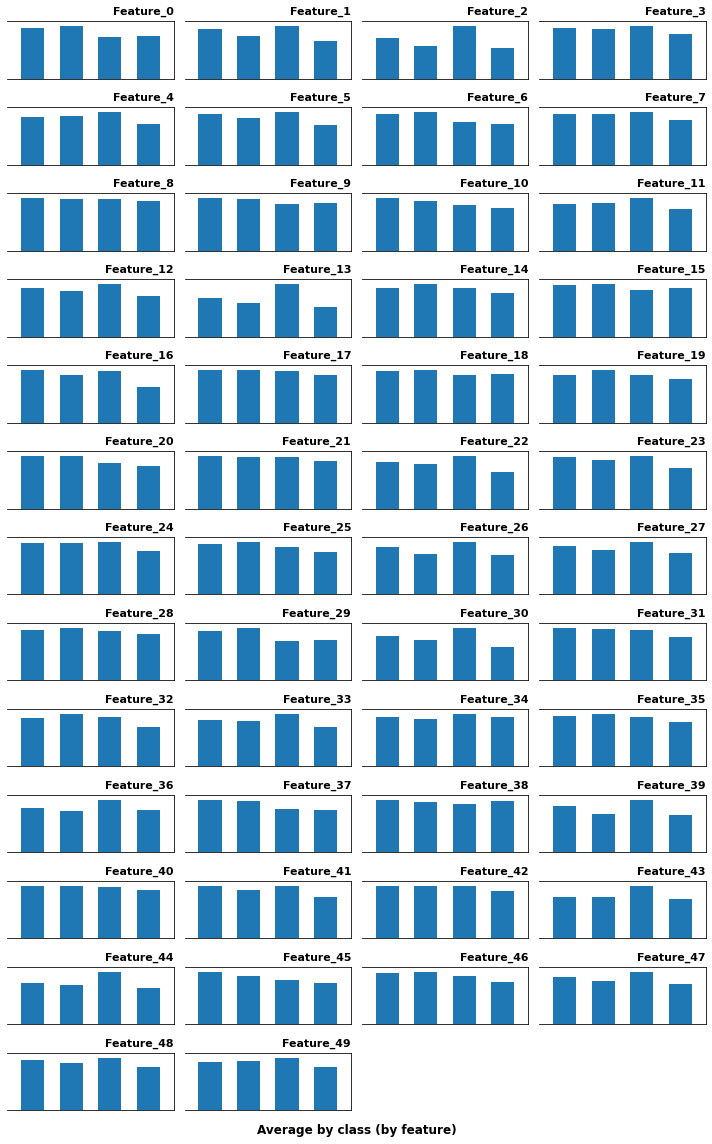

In [25]:
# Shamelessly stolen from https://www.kaggle.com/subinium/tps-may-categorical-eda
# because I thought it looked cool.
# This is supposed to be a learning exercise for me so I want to document what this does

# Create a set of plots 13 plots tall and 4 plots wide, because we need 50 and 13x4 = 52.
fig, axes = plt.subplots(13, 4, figsize=(10, 16))

# List the classes in the most obvious order
target_order = sorted(train_y.unique())

# Get the mean and std dev of each feature within each class prediction. IE, take all 
# of the 'class 1' rows and get the mean / std dev of each feature.
mean = train_X.groupby('target').mean().sort_index()
std = train_X.groupby('target').std().sort_index()

# For each feature and plot, create a bar plot of the mean as described above. Remove the ticks
# and labels, narrow the margins, put a title in, and hide plots #51 and 52 since they don't really
# exist.
for idx, ax in zip(range(50), axes.flatten()):
    ax.bar(mean[f'feature_{idx}'].index, mean[f'feature_{idx}'], width=0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(0.1)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'Feature_{idx}', loc='right', weight='bold', fontsize=11)

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

fig.supxlabel('Average by class (by feature)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

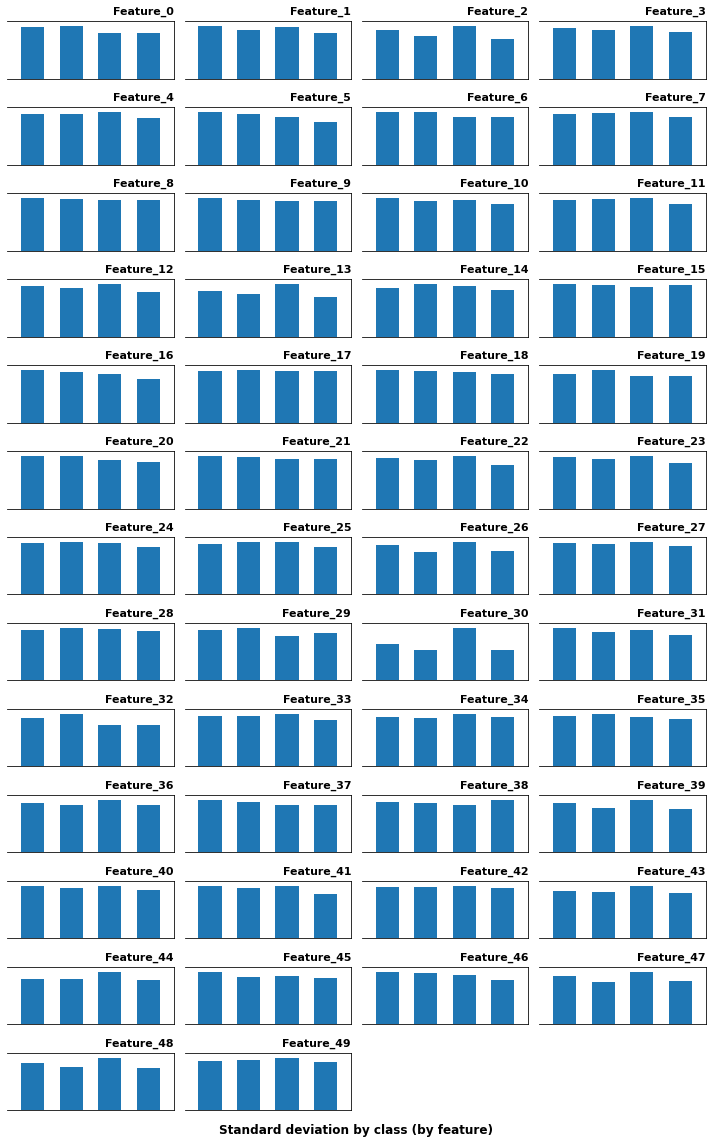

In [26]:
# Shamelessly stolen from https://www.kaggle.com/subinium/tps-may-categorical-eda
# because I thought it looked cool.
# This is supposed to be a learning exercise for me so I want to document what this does

# Create a set of plots 13 plots tall and 4 plots wide, because we need 50 and 13x4 = 52.
fig, axes = plt.subplots(13, 4, figsize=(10, 16))

# List the classes in the most obvious order
target_order = sorted(train_y.unique())

# Get the mean and std dev of each feature within each class prediction. IE, take all 
# of the 'class 1' rows and get the mean / std dev of each feature.
mean = train_X.groupby('target').mean().sort_index()
std = train_X.groupby('target').std().sort_index()

# For each feature and plot, create a bar plot of the mean as described above. Remove the ticks
# and labels, narrow the margins, put a title in, and hide plots #51 and 52 since they don't really
# exist.
for idx, ax in zip(range(50), axes.flatten()):
    ax.bar(std[f'feature_{idx}'].index, std[f'feature_{idx}'], width=0.6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(0.1)
    ax.spines['left'].set_visible(False)
    ax.set_title(f'Feature_{idx}', loc='right', weight='bold', fontsize=11)

axes.flatten()[-1].axis('off')    
axes.flatten()[-2].axis('off')

fig.supxlabel('Standard deviation by class (by feature)', ha='center', fontweight='bold')

fig.tight_layout()
plt.show()

It's clear that there are differences in the mean / standard deviation of many features when calculated with respect to class in the training data. However, it may be that not all features are predictive. Now, what's the total number of values in each column?

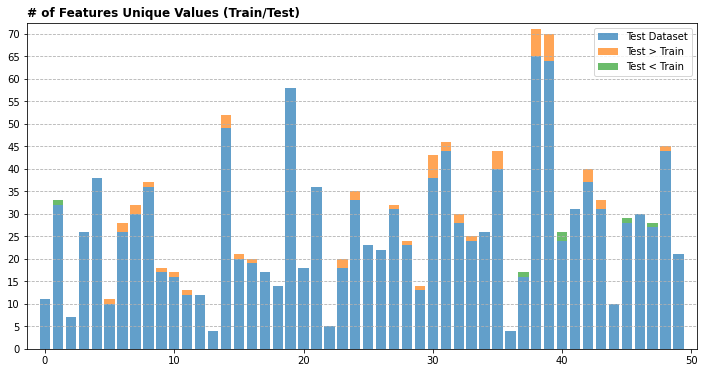

In [27]:
# Again, this is stolen
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

y = np.array([train_X[f'feature_{i}'].nunique() for i in range(50)])
y2 = np.array([test_X[f'feature_{i}'].nunique() for i in range(50)])
comp = y-y2


ax.bar(range(50), y2, alpha=0.7, label='Test Dataset')
ax.bar(range(50),  comp*(comp>0), bottom=y2, alpha=0.7, label='Test > Train')
ax.bar(range(50), comp*(comp<0), bottom=y2-comp*(comp<0), alpha=0.7, label='Test < Train')

ax.set_yticks(range(0, 80, 5))
ax.margins(0.02)
ax.grid(axis='y', linestyle='--', zorder=5)
ax.set_title('# of Features Unique Values (Train/Test)', loc='left', fontweight='bold')
ax.legend()
plt.show()

In [28]:
categorical_features = data_X.nunique()

In [29]:
discrete_features = categorical_features <= 12

## Mutual information
I wanted to see the 'mutual information' from the Kaggle courses. In the line just above this we make an assumption about which features are truly categorical and which aren't. We don't know for sure which ones they are, if there are any.

In [30]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

In [31]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(train_X.drop('target',axis=1), train_y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

feature_41    0.004983
feature_15    0.003440
feature_9     0.002924
feature_14    0.002370
feature_2     0.001949
feature_48    0.001683
feature_13    0.001297
feature_32    0.001195
feature_18    0.000887
feature_0     0.000826
feature_46    0.000704
feature_11    0.000317
feature_8     0.000227
feature_23    0.000044
feature_28    0.000000
feature_26    0.000000
feature_30    0.000000
Name: MI Scores, dtype: float64

Seems weird to me. Seems like features 10 and 2 (for example) have something to do with Class 3, but they don't show up on this list as contributing significant relationship to the class predictions.

# XGBoost
I'm just going to try it with no tuning or messing around whatsoever.

In [32]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [33]:
model1 = XGBClassifier(random_state = 14000605)
model1.fit(train_X.drop('target',axis=1), train_y)

/home/jdunavin/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=14000605, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
preds = model1.predict_proba(test_X)

/home/jdunavin/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [35]:
submission3 = pd.DataFrame(preds)

In [36]:
submission3.columns = ['Class_1', 'Class_2','Class_3','Class_4']
submission3.index = range(100000, 150000, 1)
submission3.index.name = 'id'
submission3.head()

,Class_1,Class_2,Class_3,Class_4
id,,,,
100000,0.108131,0.496554,0.269379,0.125936
100001,0.102680,0.582210,0.200891,0.114219
100002,0.077867,0.662646,0.169580,0.089906
100003,0.075213,0.585481,0.268254,0.071052
100004,0.076064,0.621155,0.192556,0.110225


In [37]:
submission3.to_csv('xgboost1_submission.csv', header=True)

That was enough to move me to 409th place with a score of 1.09459. The current numero uno has a score of 1.08497.

In [41]:
# Tuning parameters
# n_estimators
# early_stopping_rounds
# learning_rate
param_grid = {
     'max_depth': [2 ,3, 4],
     'learning_rate': [0.3, 0.2, 0.1],
     'gamma': [0.25,0.50],
     'reg_lambda' : [5, 10] #10
 }
optimal_params = GridSearchCV(
     estimator=XGBClassifier(eval_metric=['mlogloss'], seed=14000605, use_label_encoder=False, colsample_bytree=0.5, subsample=0.9),
     param_grid=param_grid,
     scoring = 'neg_log_loss',
     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     cv = 3
 )

In [52]:
# dividing X, y into train and test data
X_train, X_val, y_train, y_val = train_test_split(train_X.drop(columns=["target"]), train_y_num, random_state = 0, stratify=train_y)

In [44]:
#optimal_params.fit(X_train,y_train,early_stopping_rounds=30,eval_set=[(X_val, y_val)],verbose=50)
#print(optimal_params.best_params_)

The above found max depth = 3, learning_rate = 0.2, gamma = 0.25, reg_lambda = 10.

In [64]:
model2 = XGBClassifier(objective='multi:softprob', 
                            seed=14000605, 
                            use_label_encoder=False, 
                            colsample_bytree=0.5, 
                            subsample=0.9,
                            eta=0.3,
                            gamma = 0.25,
                            max_depth = 3,
                            reg_lambda = 10,
                            n_estimators = 200,
                            learning_rate=0.2
                            )

In [66]:
model2.fit(train_X.drop('target',axis=1), train_y_num, verbose=True, early_stopping_rounds=30, eval_metric=['mlogloss'], eval_set=[(X_train, y_train),(X_val, y_val)])

[0]	validation_0-mlogloss:1.31091	validation_1-mlogloss:1.31073
[1]	validation_0-mlogloss:1.25778	validation_1-mlogloss:1.25748
[2]	validation_0-mlogloss:1.21955	validation_1-mlogloss:1.21894
[3]	validation_0-mlogloss:1.19135	validation_1-mlogloss:1.19067
[4]	validation_0-mlogloss:1.17050	validation_1-mlogloss:1.16970
[5]	validation_0-mlogloss:1.15485	validation_1-mlogloss:1.15390
[6]	validation_0-mlogloss:1.14312	validation_1-mlogloss:1.14223
[7]	validation_0-mlogloss:1.13424	validation_1-mlogloss:1.13336
[8]	validation_0-mlogloss:1.12756	validation_1-mlogloss:1.12669
[9]	validation_0-mlogloss:1.12238	validation_1-mlogloss:1.12149
[10]	validation_0-mlogloss:1.11839	validation_1-mlogloss:1.11736
[11]	validation_0-mlogloss:1.11526	validation_1-mlogloss:1.11418
[12]	validation_0-mlogloss:1.11282	validation_1-mlogloss:1.11167
[13]	validation_0-mlogloss:1.11082	validation_1-mlogloss:1.10962
[14]	validation_0-mlogloss:1.10919	validation_1-mlogloss:1.10795
[15]	validation_0-mlogloss:1.10782	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eta=0.3, gamma=0.25,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=14000605, reg_alpha=0,
              reg_lambda=10, scale_pos_weight=None, seed=14000605,
              subsample=0.9, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [68]:
predicted_classes = model2.predict(X_val) # used only for confusion matrix later, therefore with X_val
predictions = model2.predict_proba(test_X) # used for submission
predictions

/home/jdunavin/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([[0.09717217, 0.62054884, 0.17037714, 0.11190186],
       [0.0667738 , 0.72017974, 0.13861187, 0.07443464],
       [0.08481854, 0.6324009 , 0.18872185, 0.09405871],
       ...,
       [0.08187401, 0.5300071 , 0.21470273, 0.17341615],
       [0.08559196, 0.5934731 , 0.16200021, 0.15893479],
       [0.0960421 , 0.5649489 , 0.21310739, 0.12590161]], dtype=float32)

In [70]:
submission4 = pd.DataFrame(predictions)
submission4.columns = ['Class_1', 'Class_2','Class_3','Class_4']
submission4.index = range(100000, 150000, 1)
submission4.index.name = 'id'
# Fix the identified class labels from above


In [82]:
#submission4.loc[143290] = [0,1,0,0]
#submission4.loc[132008] = [0,0,1,0]
#submission4.loc[143128] = [0,0,1,0]
#submission4.loc[114762] = [0,0,0,1]
#submission4.loc[101165] = [0,0,1,0]
#submission4.loc[120746] = [0,1,0,0]
# WEIRD - when I fixed these rows, my public score went DOWN

In [83]:
#23271 143290
#31715 132008
#36456 143128
#62186 114762
#63139 101165
#81432 120746
#save_preds

In [78]:
submission4.to_csv('xgbtuned_submission.csv', header=True)

This was good for a public score of 1.08776, good enough for number 206 as of this writing. Seems like it will be quite a bit harder to extract further improvement. Domain knowledge is not useful here and I've exhausted the limit of my (limited) learning about xgboost.

Accuracy: 0.5842067365389231

Confusion Matrix:


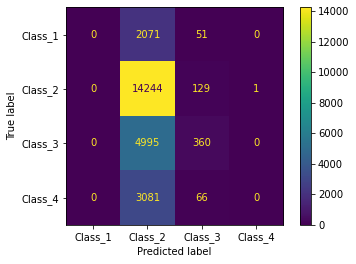

In [72]:
class_labels = ["Class_1","Class_2","Class_3","Class_4"]
plot_confusion_matrix(model2, X_val, y_val, display_labels=class_labels)
print("Accuracy: {}\n".format(accuracy_score(y_val,predicted_classes)))
print("Confusion Matrix:")

In [79]:
pd.Series(predicted_classes).value_counts(normalize=True)

1    0.975718
2    0.024242
3    0.000040
dtype: float64

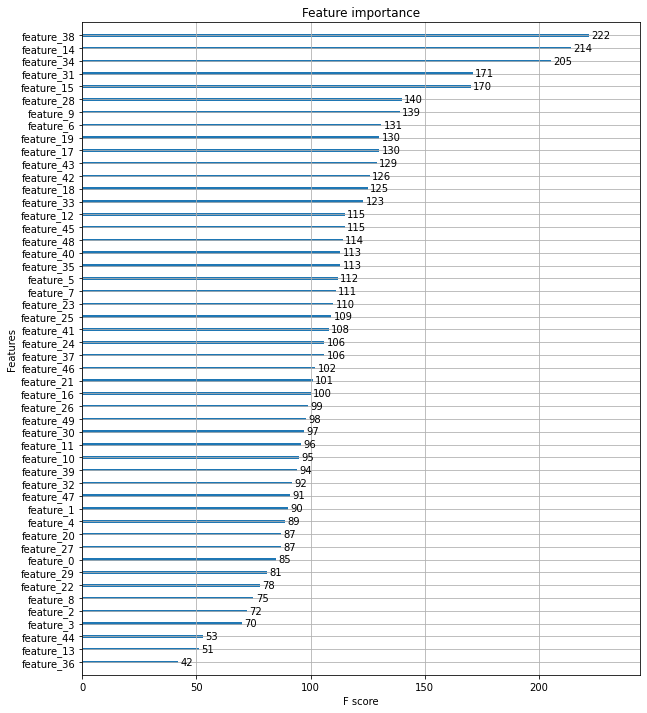

In [81]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model2,(10,12) )
plt.show()

So the model above caught a very small number of class 3s and none of the class 1s. Feature importances are shown above. It's hard to tell what additional feature engineering can be done here.

Now let's try the xgboost random forest classifier.

In [85]:
from xgboost import XGBRFClassifier
param_grid = {
     'max_depth': [2 ,3, 4],
     'learning_rate': [0.3, 0.2, 0.1],
     'gamma': [0.25,0.35,0.45],
     'reg_lambda' : [1e-04, 1e-05, 1e-06] #10
 }
optimal_params = GridSearchCV(
     estimator=XGBRFClassifier(eval_metric=['mlogloss'], seed=14000605, use_label_encoder=False, colsample_bytree=0.5, subsample=0.9),
     param_grid=param_grid,
     scoring = 'neg_log_loss',
     verbose=0, # NOTE: If you want to see what Grid Search is doing, set verbose=2
     cv = 3
 )

In [86]:
# dividing X, y into train and test data
X_train, X_val, y_train, y_val = train_test_split(train_X.drop(columns=["target"]), train_y_num, random_state = 14000605, stratify=train_y)

In [90]:
#optimal_params.fit(X_train,y_train,early_stopping_rounds=30,eval_set=[(X_val, y_val)],verbose=0)

In [89]:
print(optimal_params.best_params_)

{'gamma': 0.45, 'learning_rate': 0.3, 'max_depth': 4, 'reg_lambda': 1e-06}


In [91]:
model3 = XGBRFClassifier(objective='multi:softprob', 
                            seed=14000605, 
                            use_label_encoder=False, 
                            colsample_bytree=0.5, 
                            subsample=0.9,
                            eta=0.3,
                            gamma = 0.45,
                            max_depth = 4,
                            reg_lambda = 1e-06,
                            n_estimators = 200,
                            learning_rate=0.3
                            )

In [92]:
model3.fit(train_X.drop('target',axis=1), train_y_num, verbose=True, early_stopping_rounds=30, eval_metric=['mlogloss'], eval_set=[(X_train, y_train),(X_val, y_val)])

[0]	validation_0-mlogloss:1.27632	validation_1-mlogloss:1.27657


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=0.5, eta=0.3, gamma=0.45, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.3, max_delta_step=0, max_depth=4,
                min_child_weight=1, missing=nan, monotone_constraints='()',
                n_estimators=200, n_jobs=4, num_parallel_tree=200,
                objective='multi:softprob', random_state=14000605, reg_alpha=0,
                reg_lambda=1e-06, scale_pos_weight=None, seed=14000605,
                subsample=0.9, tree_method='exact', use_label_encoder=False,
                validate_parameters=1, verbosity=None)

In [93]:
predicted_classes = model3.predict(X_val) # used only for confusion matrix later, therefore with X_val
predictions = model3.predict_proba(test_X) # used for submission
predictions

/home/jdunavin/.local/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


array([[0.21593553, 0.32538506, 0.2369956 , 0.22168386],
       [0.21594402, 0.31828424, 0.24276723, 0.22300446],
       [0.2171761 , 0.32070962, 0.24087994, 0.22123434],
       ...,
       [0.2170351 , 0.31442416, 0.24118154, 0.22735919],
       [0.21759889, 0.3155815 , 0.24133071, 0.22548895],
       [0.21577385, 0.31932342, 0.23916014, 0.2257426 ]], dtype=float32)

Accuracy: 0.5750060004800384

Confusion Matrix:


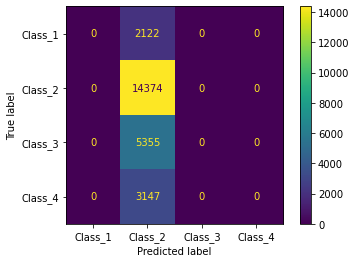

In [94]:
plot_confusion_matrix(model3, X_val, y_val, display_labels=class_labels)
print("Accuracy: {}\n".format(accuracy_score(y_val,predicted_classes)))
print("Confusion Matrix:")

This obviously sucks much worse than the previous model, and is essentially the same as predicting class 2 the whole way.

In [95]:
submission5 = pd.DataFrame(predictions)
submission5.columns = ['Class_1', 'Class_2','Class_3','Class_4']
submission5.index = range(100000, 150000, 1)
submission5.index.name = 'id'

In [96]:
submission5.to_csv('junk_submission.csv', header=True)